In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
import random

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Iperparametri

In [2]:
#general
logLabel = "log44"
print_period = 50
use_dummies_input = True

#regularizzation
use_dropout = False
input_dropout_rate = 0.3
dropout_rate = 0.5

#layer size
use_layer_regression = True
hidden_layers = 1
n_hidden = 50
activation_function = tf.nn.relu

#training
learning_rate = 0.01
scale_input_data = False
scale_output_data = True
batch_size = 10
epochs = 3000
patience = 16
min_delta = 0.001

## Ottiene i dati

In [3]:
df = pd.read_csv('patterns.csv')
#print(df.head(5))

#ottiene input e output
if use_dummies_input:
    X1 = pd.get_dummies(df.iloc[:, 0]).values.astype(np.float32)
    X2 = pd.get_dummies(df.iloc[:, 24]).values.astype(np.float32)
    for i in range(1,24):
        X1_dummy = pd.get_dummies(df.iloc[:, i]).values.astype(np.float32)
        X2_dummy = pd.get_dummies(df.iloc[:, i+24]).values.astype(np.float32)
        X1 = np.concatenate((X1, X1_dummy), axis=1)
        X2 = np.concatenate((X2, X2_dummy), axis=1)
else:
    X1 = df.iloc[:, :24].values.astype(np.float32)
    X2 = df.iloc[:, 24:48].values.astype(np.float32)
Y = df.iloc[:, -1:].values.astype(np.float32)

#separa dati di train da dati di test
test_size=0.33
X1_train, X1_test, X2_train, X2_test, Y_train, Y_test = train_test_split(X1, X2, Y, test_size=test_size, random_state=42)


## Crea il modello

In [4]:
tf.reset_default_graph()

#crea i placeholder di input
n_input = X1.shape[1]
inputplaceholder1 = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name="X1")
inputplaceholder2 = tf.placeholder(dtype=tf.float32, shape=[None, n_input], name="X2")
is_training = tf.placeholder(tf.bool, name="isTraining")
input_regressions = []

#crea un unico livello di input, per avere solo un hidden layer denso (da commentare le successive 2 sezioni)
if not use_layer_regression:
    input_regressions.append(inputplaceholder1)
    input_regressions.append(inputplaceholder2)

In [5]:
if use_layer_regression:
    #2 regressioni full
    with tf.variable_scope("regression_full1") as scope:
        #weights = tf.Variable(tf.random_normal([n_input, 1]))
        #biases = tf.Variable(tf.zeros([1]))
        #layer = tf.matmul(inputplaceholder1, weights)
        #layer = tf.add(layer, biases)
        #layer_full_1 = tf.nn.sigmoid(layer)
        layer_full_1 = tf.layers.dense(inputplaceholder1, 1, activation=activation_function)
        if use_dropout:
                layer_full_1 = tf.layers.dropout(layer_full_1, rate=input_dropout_rate, training=is_training)
        input_regressions.append(layer_full_1)
    
    with tf.variable_scope("regression_full2") as scope:
        #weights = tf.Variable(tf.random_normal([n_input, 1]))
        #biases = tf.Variable(tf.zeros([1]))
        #layer = tf.matmul(inputplaceholder2, weights)
        #layer = tf.add(layer, biases)
        #layer_full_2 = tf.nn.sigmoid(layer)
        layer_full_2 = tf.layers.dense(inputplaceholder2, 1, activation=activation_function)
        if use_dropout:
                layer_full_2 = tf.layers.dropout(layer_full_2, rate=input_dropout_rate, training=is_training)
        input_regressions.append(layer_full_2)

In [6]:
if use_layer_regression:
    #per ogni coppia di input crea una regressione
    with tf.variable_scope("regression_couple") as scope:    
        for i in range(n_input):
            if use_dummies_input:
                layer_input = tf.concat([inputplaceholder1[:, i:i+5+1], inputplaceholder2[:, i:i+5+1]], 1)
            else:    
                layer_input = tf.concat([inputplaceholder1[:, i:i+1], inputplaceholder2[:, i:i+1]], 1)
            #weights = tf.Variable(tf.random_normal([2, 1]))
            #biases = tf.Variable(tf.zeros([1]))
            #layer = tf.matmul(layer_input, weights)
            #layer = tf.add(layer, biases)
            #layer = tf.nn.sigmoid(layer)
            layer = tf.layers.dense(layer_input, 1, activation=activation_function)
            if use_dropout:
                layer = tf.layers.dropout(layer, rate=input_dropout_rate, training=is_training)
            input_regressions.append(layer)

In [7]:
#concatena tutte le regressioni di ingresso (o solo gli input)
regression_layer = tf.concat(input_regressions, 1)

#crea il primo livello hidden
with tf.variable_scope("hidden_1") as scope:
    #regression_layer_size = int(regression_layer.shape[1])
    #weights = tf.Variable(tf.random_normal([regression_layer_size, n_hidden]))
    #biases = tf.Variable(tf.zeros([n_hidden]))
    #layer = tf.matmul(regression_layer, weights)
    #layer = tf.add(layer, biases)
    #hidden_layer = tf.nn.sigmoid(layer)
    hidden_layer = tf.layers.dense(regression_layer, n_hidden, activation=activation_function)
    if use_dropout:
        hidden_layer = tf.layers.dropout(hidden_layer, rate=dropout_rate, training=is_training)

#crea gli altri livelli hidden
for i in range(2, hidden_layers + 1):
    with tf.variable_scope("hidden_"+str(i)) as scope:
        #weights = tf.Variable(tf.random_normal([n_hidden, n_hidden]))
        #biases = tf.Variable(tf.zeros([n_hidden]))
        #layer = tf.matmul(hidden_layer, weights)
        #layer = tf.add(layer, biases)
        #hidden_layer = tf.nn.sigmoid(layer)
        hidden_layer = tf.layers.dense(hidden_layer, n_hidden, activation=activation_function)
        if use_dropout:
            hidden_layer = tf.layers.dropout(hidden_layer, rate=dropout_rate, training=is_training)
    
#crea il livello output
n_output = 1
with tf.variable_scope("output") as scope:
    #weights = tf.Variable(tf.random_normal([n_hidden, n_output]))
    #biases = tf.Variable(tf.zeros([n_output]))
    #layer = tf.matmul(hidden_layer, weights)
    #layer = tf.add(layer, biases)
    output_layer = tf.layers.dense(hidden_layer, n_output)

In [8]:
#crea il placeholder delle label, la funzione di costo e l'optimizer
labelsplaceholder = tf.placeholder(dtype=tf.float32, shape=[None,n_output], name='Y')
loss = tf.losses.mean_squared_error(labelsplaceholder, output_layer)

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

train_loss_summary = tf.summary.scalar('loss', loss)
test_loss_summary = tf.summary.scalar('val_loss', loss)

## Effettua il training

In [9]:
#init
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
writer = tf.summary.FileWriter(logdir='logs/'+logLabel , graph=tf.get_default_graph())
saver = tf.train.Saver()

#effettua lo scaler dei dati di ingresso
if scale_input_data:
    X_alldata = np.concatenate((X1, X2), axis=0)
    scalerX = preprocessing.MinMaxScaler().fit(X_alldata)
    X1_train_scaled = scalerX.transform(X1_train)
    X2_train_scaled = scalerX.transform(X2_train)
    X1_test_scaled = scalerX.transform(X1_test)
    X2_test_scaled = scalerX.transform(X2_test)
else:
    X1_train_scaled = X1_train
    X2_train_scaled = X2_train
    X1_test_scaled = X1_test
    X2_test_scaled = X2_test

#effettua lo scaler dei dati di uscita
if scale_output_data:
    scalerY = preprocessing.MinMaxScaler().fit(Y)
    Y_train_scaled = scalerY.transform(Y_train)
    Y_test_scaled = scalerY.transform(Y_test)
else:
    Y_train_scaled = Y_train
    Y_test_scaled = Y_test

In [10]:
#effettua il training
train_history_loss = list()
test_history_loss  = list()
patience_cnt = 0
res_prec_loss = float('inf')
for epoch in range(epochs):
    
    #prepara il batch
    inputdata1 = list()
    inputdata2 = list()
    output_data = list()
    for _ in range(batch_size):
        i = np.random.randint(len(Y_train))
        inputdata1.append(X1_train_scaled[i,:])
        inputdata2.append(X2_train_scaled[i,:])
        output_data.append(Y_train_scaled[i,:])

    #effettua il train
    feed_dict = {
      labelsplaceholder: output_data,
      inputplaceholder1: inputdata1,
      inputplaceholder2: inputdata2,
      is_training: True
    }
    res_optimizer, res_loss, res_train_lost_summary = sess.run([optimizer, loss, train_loss_summary], feed_dict=feed_dict)
    
    #preiodicamente stampa la loss del train e ricalcola i dati di test per ottenere la loss di validazione
    save_loss = epoch % int(print_period * epochs / 1000) == 0
    if save_loss:
        #conserva la loss di train
        train_history_loss.append(res_loss)
        writer.add_summary(res_train_lost_summary, epoch)

        #effettua la validazione
        i = np.random.randint(len(Y_test))
        feed_dict = {
          labelsplaceholder: [Y_test_scaled[i,:]],
          inputplaceholder1: [X1_test_scaled[i,:]],
          inputplaceholder2: [X2_test_scaled[i,:]],
          is_training: False
        }
        res_loss, res_test_loss_summary = sess.run([loss, test_loss_summary], feed_dict=feed_dict)
        
        #conserva la loss di validazione
        test_history_loss.append(res_loss)
        writer.add_summary(res_test_loss_summary, epoch)

    #gestisce l'early stopping
    if epoch > 0 and res_prec_loss-res_loss > min_delta:
        patience_cnt = 0
    else:
        patience_cnt += 1
    res_prec_loss = res_loss
    if patience_cnt > patience:
        print("early stopping... epoch: ", epoch)
        break
           
#salva il modello e gli scaler
saver.save(sess, "./saved/model.ckpt")
if scale_input_data:
    joblib.dump(scalerX, './saved/scalerX.pkl') 
if scale_output_data:
    joblib.dump(scalerY, './saved/scalerY.pkl') 

## Stampa le perdite

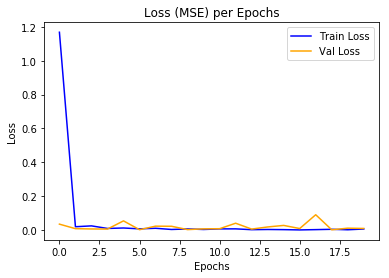

In [11]:
#stampo la perdita
start_plot_index = 0
plt.plot(train_history_loss[start_plot_index:], 'blue', label='Train Loss')
plt.plot(test_history_loss[start_plot_index:], 'orange', label='Val Loss')
plt.title('Loss (MSE) per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## Effettua le predictions

In [12]:
#ottiene l'output dai dati di test
feed_dict = {
  inputplaceholder1: X1_test_scaled,
  inputplaceholder2: X2_test_scaled,
  is_training: False
}
res_output_layer = sess.run([output_layer], feed_dict=feed_dict)

#trasforma gli output in predictions
predictions = []
res_output_layer_unscaled = scalerY.inverse_transform(res_output_layer[0])
for i in range(len(res_output_layer_unscaled)):
    predictions.append(res_output_layer_unscaled[i][0])

#trasforma i dati Y di test in labels    
labels = []
for i in range(len(Y_test)):
    labels.append(Y_test[i][0])

In [13]:

##prova una support vector machine
#from sklearn.svm import SVR
#svr = SVR(kernel='poly', C=1e3, degree=2)
#X_train = np.concatenate((X1_train_scaled, X2_train_scaled), axis=1)
#X_test = np.concatenate((X1_test_scaled, X2_test_scaled), axis=1)
#svr.fit(X_train, Y_train)
#predictions = svr.predict(X_test)

## Valuta il modello

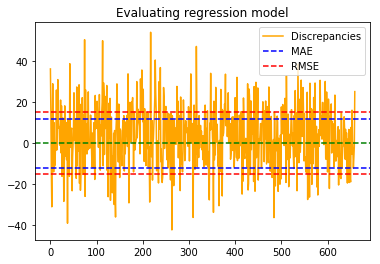

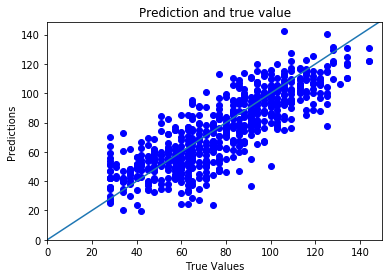

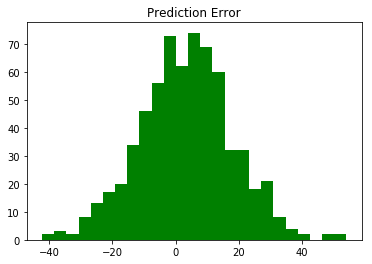

MAE:  11.936453  (→ 0)
RMSE:  15.098153998101576  (→ 0)
R^2:  0.6714931028047824  (→ 1)


In [14]:
#ottiene l' R^2 score (ottimo valore se tendente a 1)
r_square = r2_score(labels, predictions) 

#ottiene il Mean Absolute Error (MAE) (ottimo valore se tendente a 0)
mae = mean_absolute_error(labels, predictions)

#ottiene il Root Mean Squared Error (RMSE) (ottimo valore se tendente a 0)
rmse = mean_squared_error(labels, predictions)**0.5

#stampa le varie discrepanze (differenza tra il valore atteso ed il valore predetto)
discrepancies = []
for i in range(len(labels)):
    discrepancies.append(labels[i]-predictions[i])
plt.title('Evaluating regression model')
plt.plot(discrepancies, label='Discrepancies', color='orange')
plt.axhline(y=mae, color='b', linestyle='--', label='MAE')
plt.axhline(y=-mae, color='b', linestyle='--')
plt.axhline(y=rmse, color='r', linestyle='--', label='RMSE')
plt.axhline(y=-rmse, color='r', linestyle='--')
plt.axhline(y=-0, color='g', linestyle='--')
plt.legend(loc='upper right')
plt.show()

#predictions e true value
plt.scatter(labels, predictions, color='blue')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction and true value')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-500, 500], [-500, 500])
plt.show()

#distribuzione degli errori
plt.hist(discrepancies, bins=25, color='green')
plt.title("Prediction Error")
plt.show()

#stampa i risultati
print("MAE: ", mae, " (→ 0)")
print("RMSE: ", rmse, " (→ 0)")
print("R^2: ", r_square, " (→ 1)")